In [ ]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
troncho_base = '/content/drive/MyDrive/Your_Drive'
os.chdir(troncho_base)
sys.path.append(troncho_base)

Mounted at /content/drive


In [ ]:
!pip install munch
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [ ]:
import torch
# Import Local
from stats.trace import plot
from src.utils import config
from src.loaddataset import load_dataset_for_inference
from src.buildmodel import build_model
from src.utils.modelfile import load_model
from stats.confusion_matrix import get_confusion_matrix, plot_confusion_matrix

def build_and_load_model(parameters, model_file ):
    model, device = build_model(parameters)
    load_model(parameters=parameters, model=model, model_file=model_file+'.pth')
    model.eval()
    return model, device

In [ ]:
#Loading data
from pytorch_grad_cam import LayerCAM, GradCAM, HiResCAM, GradCAMPlusPlus, ScoreCAM, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

results_cams = []
results_cams.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_cams_masked_he.npy'))
results_cams.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_cams_originals.npy'))
results_cams.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_cams_omasks.npy'))

results_imgs = []
results_imgs.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_imgs_masked_he.npy'))
results_imgs.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_imgs_originals.npy'))
results_imgs.append(np.load('/content/drive/MyDrive/ai-sex-class-paper-main/results_allruns_imgs_omasks.npy'))

In [ ]:
#Checking the shapes
print('cams_masked_he', results_cams[0].shape)
print('cams_original', results_cams[1].shape)
print('cams_only_masks', results_cams[2].shape)
print('img_masked_he', results_imgs[0].shape)
print('img_original', results_imgs[1].shape)
print('img_only_masks', results_imgs[2].shape)

cams_masked_he (2, 10, 6, 1, 10, 400, 300)
cams_original (2, 10, 6, 1, 10, 400, 300)
cams_only_masks (2, 10, 6, 1, 10, 400, 300)
img_masked_he (2, 10, 400, 300, 3)
img_original (2, 10, 400, 300, 3)
img_only_masks (2, 10, 400, 300, 3)


In [ ]:
#creating data sets
kbest_f_mhe_idxs = [134, 98, 137, 110, 148, 187, 128, 114, 122, 152]
kbest_m_mhe_idxs = [ 91, 16, 53, 63, 86, 78,  82, 31,  6, 15]
kbest_f_org_idxs = [117, 141, 137, 143, 132, 174, 170,  183,  185,  113]
kbest_m_org_idxs = [64, 15, 60, 75, 79, 83, 23, 65, 16, 90]
kbest_f_omask_idxs = [98, 134, 148,  173,  187,  138, 142, 195, 162, 170]
kbest_m_omask_idxs = [86, 16, 53, 6, 31, 9, 59, 69, 29, 43]

tst_file = './datasets/xray_masked_he/tst_masked_he_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('masked_he', images.shape)
best_female_mhe = images[kbest_f_mhe_idxs]
best_male_mhe = images[kbest_m_mhe_idxs]

tst_file = './datasets/xray_original/tst_original_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('original', images.shape)
best_female_org = images[kbest_f_org_idxs]
best_male_org   = images[kbest_m_org_idxs]

tst_file = './datasets/only_masks/tst_masks_400x300.npz'
data = np.load(tst_file)
images = data['data']/255
print('only masks', images.shape)
best_female_omask = images[kbest_f_omask_idxs]
best_male_omask   = images[kbest_m_omask_idxs]


data_shape      = [best_male_mhe.shape, best_male_org.shape, best_male_omask.shape]

data_sets       = [[best_female_mhe, best_male_mhe],
                   [best_female_org, best_male_org],
                   [best_female_omask, best_male_omask],]

data_sets_names = [['best_female_mhe', 'best_male_mhe'],
                   ['best_female_org', 'best_male_org'],
                   ['best_female_omask', 'best_male_omask'],]

data_sets_idxs  = [[kbest_f_mhe_idxs, kbest_m_mhe_idxs],
                   [kbest_f_org_idxs, kbest_m_org_idxs],
                   [kbest_f_omask_idxs, kbest_m_omask_idxs],]
class_output    = [0, 1]

masked_he (196, 400, 300)
original (200, 400, 300)
only masks (196, 400, 300)


In [ ]:
#visualizing all methods. Not needed, only for cheking
'''
def vizualization(name, indexs, img, gray_cams):
    fig = plt.figure(figsize=(6, 20))
    axes = fig.subplots(len(indexs), 3)
    for j in range(len(indexs)):

        axes[j,0].imshow(np.uint8(255*img[j])[:,:,0], cmap='gray')
        axes[j,0].set_xticks([])
        axes[j,0].set_yticks([])
        axes[j,0].set_title(f'imgidx={str(indexs[j])}', fontsize=8)

        cam = np.uint8(255*gray_cams[j])
        cam = cv2.merge([cam, cam, cam])
        axes[j,1].imshow(cam)
        axes[j,1].set_xticks([])
        axes[j,1].set_yticks([])

        xray_image = np.array([img[j][:,:,0], img[j][:,:,0], img[j][:,:,0]]).transpose(1,2,0)
        cam_image = show_cam_on_image(xray_image, gray_cams[j], use_rgb=True)
        axes[j,2].imshow(cam_image)
        axes[j,2].set_xticks([])
        axes[j,2].set_yticks([])
        fig.suptitle(name, y=0.92)
    plt.show()


k = 5 #method LayerCam
number_of_runs = 10
model_name = ['xray_masked_he', 'xray_original', 'only_masks']
cams_names = ['GradCAM', 'GradCAMPlusPlus', 'XGradCAM', 'EigenCAM', 'HiResCAM',  'LayerCAM']

for d in range(len(model_name)): #by models
    for i, idxs in enumerate(data_sets_idxs[d]): #by datasets indx
        for j in range(number_of_runs): #by runs
            name = f'Model:{model_name[d]}, run:{str(j+1)}, method:{cams_names[k]}, dataset:{data_sets_names[d][i]}'
            vizualization(name, idxs, results_imgs[d][i], results_cams[d][i,j,k,0])
'''

"\ndef vizualization(name, indexs, img, gray_cams):\n    fig = plt.figure(figsize=(6, 20))\n    axes = fig.subplots(len(indexs), 3)\n    for j in range(len(indexs)):\n\n        axes[j,0].imshow(np.uint8(255*img[j])[:,:,0], cmap='gray')\n        axes[j,0].set_xticks([])\n        axes[j,0].set_yticks([])\n        axes[j,0].set_title(f'imgidx={str(indexs[j])}', fontsize=8)\n\n        cam = np.uint8(255*gray_cams[j])\n        cam = cv2.merge([cam, cam, cam])\n        axes[j,1].imshow(cam)\n        axes[j,1].set_xticks([])\n        axes[j,1].set_yticks([])\n\n        xray_image = np.array([img[j][:,:,0], img[j][:,:,0], img[j][:,:,0]]).transpose(1,2,0)\n        cam_image = show_cam_on_image(xray_image, gray_cams[j], use_rgb=True)\n        axes[j,2].imshow(cam_image)\n        axes[j,2].set_xticks([])\n        axes[j,2].set_yticks([])\n        fig.suptitle(name, y=0.92)\n    plt.show()\n\n\nk = 5 #method LayerCam\nnumber_of_runs = 10\nmodel_name = ['xray_masked_he', 'xray_original', 'only_mask

In [ ]:
models_parameters = [config.load_parameters('xray_masked_he'), config.load_parameters('xray_original'),
                     config.load_parameters('only_masks') ]
models_names = ['xray_masked_he', 'xray_original', 'only_masks']

models_with_runs = []
number_of_runs = 10

for i, param in enumerate(models_parameters):  #by models
    runs = []
    print(f'**Model**:{models_names[i]}')
    for k in range(1,number_of_runs+1):  #by runs
        print(f'****run****:{k}')
        model, device = build_and_load_model(param, models_names[i]+'_run'+str(k))
        runs.append(model)
    models_with_runs.append(runs)

**Model**:xray_masked_he
****run****:1


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 153MB/s]


****run****:2
****run****:3
****run****:4
****run****:5
****run****:6
****run****:7
****run****:8
****run****:9
****run****:10
**Model**:xray_original
****run****:1
****run****:2
****run****:3
****run****:4
****run****:5
****run****:6
****run****:7
****run****:8
****run****:9
****run****:10
**Model**:only_masks
****run****:1
****run****:2
****run****:3
****run****:4
****run****:5
****run****:6
****run****:7
****run****:8
****run****:9
****run****:10


In [ ]:
#Obtaining the scores and storing in numpys
number_of_runs = 10
data_sets_by_models = 2
score_by_models = []

for d in range(len(models_names)): #by modelos
    print(f'Model:{models_names[d]}')
    scores_by_runs_by_dataset = np.empty((number_of_runs,  data_sets_by_models,  len(data_sets[0][0])))  #(runs, datasets, score of each image for each runs and datasets)
    for i, run in enumerate(models_with_runs[d]):   #by runs
        print(f'***run:{i}***')
        for j, ds in enumerate(data_sets[d]):      #by datasets
            print(f'*****dataset:{data_sets_names[d][j]}*****')
            ds = ds.astype(np.float32)
            ds = np.stack((ds,)*3, axis=-1)
            ds_torch = torch.from_numpy(ds).to(torch.device("cuda")).permute(0, 3, 1, 2)
            output_score = run(ds_torch)
            print(f'output_score:', output_score)
            scores = output_score.cpu().detach().numpy()
            scores_by_runs_by_dataset[i, j] = scores[:, class_output[j]]
    score_by_models.append(scores_by_runs_by_dataset)

Model:xray_masked_he
***run:0***
*****dataset:best_female_mhe*****
output_score: tensor([[ 11.9294, -10.7644],
        [ 13.6270, -12.0684],
        [ 10.7597,  -9.7235],
        [  5.4481,  -5.2828],
        [  9.2244,  -8.5672],
        [  4.7059,  -4.5125],
        [  7.0435,  -6.5987],
        [  8.6168,  -8.0115],
        [  2.6354,  -2.5357],
        [  2.5111,  -2.4552]], device='cuda:0', grad_fn=<AddmmBackward0>)
*****dataset:best_male_mhe*****
output_score: tensor([[-13.5408,  13.7390],
        [-13.7207,  13.9786],
        [-11.9229,  12.0553],
        [-12.6314,  12.7807],
        [-11.8243,  11.9938],
        [ -6.2161,   6.0970],
        [-13.4193,  13.6170],
        [ -4.4341,   4.3144],
        [-13.5565,  13.8024],
        [ -7.0292,   6.7977]], device='cuda:0', grad_fn=<AddmmBackward0>)
***run:1***
*****dataset:best_female_mhe*****
output_score: tensor([[ 11.4545, -11.1155],
        [ 15.9092, -15.3433],
        [ 12.4778, -12.0870],
        [ 12.3202, -11.9441],
     

In [ ]:
!pip3 install hdmedians
!pip install geom_median

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp310-cp310-linux_x86_64.whl size=677343 sha256=8b73e3476a916b72b7e98c21440f1c28636c7bcf25ff2d168d4720130b097719
  Stored in directory: /root/.cache/pip/wheels/82/8f/0d/0c61130cfad119482ebb95aecf8d5dfaddd0181f5680da2bec
Successfully built hdmedians
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for geom_median: filename=geom_median-0.1.0-py3-none-any.whl size=23935 sha256=8af129fd9e23929c379dc72b801eb791e678abe2e9f8ba9b78cafe8c0c02f758
  Stored in directory: /root/.cache/pip/wheels/1c/e1/08/d154badc02f013b107f92d8fdd89d88bb2362bca6b027d2fd1
Successfully built geom_median


In [ ]:
#Computing the weights for combining CAM images
from scipy.special import softmax
import hdmedians as hdm
from geom_median.numpy import compute_geometric_median

number_of_runs = 10
number_of_images = 10
data_sets_by_models = 2
cams_names = ['GradCAM', 'GradCAMPlusPlus', 'XGradCAM', 'EigenCAM', 'HiResCAM',  'LayerCAM']
lam = 2
last_dim = results_cams[0][0,0,0,0,0].shape

def median(a):
    return np.median(a, axis=0)

def mean(a):
    return np.mean(a, axis=0)

def weighted_mean(a, b):
    c = a*b
    return np.sum(c, axis=0)

def weighted_median(a, b):
    return None

def hd_medoid(a):
    h, w = a.shape[1], a.shape[2]
    b = a.reshape(a.shape[0], h*w).transpose(1,0)
    #c = np.array(hdm.geomedian(b))
    c = np.array(hdm.medoid(b))
    return c.reshape(h, w)

def hd_median(a):
    h, w = a.shape[1], a.shape[2]
    b = a.reshape(a.shape[0], h*w).transpose(1,0)
    c = np.array(hdm.geomedian(b))
    return c.reshape(h, w)

def hd_weighted_median(points, weights=None):
    h, w = points.shape[1], points.shape[2]
    points = [p for p in points]
    out = compute_geometric_median(points, weights)
    w_median = out.median
    return w_median.reshape(h, w)

finals_cams_by_models = []
for d in range(len(models_names)): #by models
    final_cams = np.empty(((data_sets_by_models, number_of_images, len(cams_names),) + last_dim)) #datasets x #images x #cams x image dimensions
    for i  in range(data_sets_by_models): #by dataset, female or male
        for j in range(number_of_images): #by images

            scores = score_by_models[d][:, i, j]  #':'= all runs
            print('scores=', scores)
            #sft_score = softmax(lam*scores)
            sft_score = scores/np.sum(scores)  #weighted average
            print('w_ave_score=', sft_score)

            for k in range(len(cams_names)): #by cam's method
                print(f'Model:{d}, dataset:{i}, image:{j}, cam:{k+1}')
                cams_combined = hd_weighted_median(results_cams[d][i,:,k,0,j], sft_score)
                final_cams[i, j, k] = cams_combined

    finals_cams_by_models.append(final_cams)

scores= [11.92939854 11.45450974  8.56953812  7.66201019  5.0615325  11.33215904
 10.01890659  8.93038559 13.16411018 12.0138073 ]
w_ave_score= [0.11913154 0.11438912 0.08557869 0.07651577 0.0505464  0.11316728
 0.10005264 0.08918225 0.13146184 0.11997448]
Model:0, dataset:0, image:0, cam:1
Model:0, dataset:0, image:0, cam:2
Model:0, dataset:0, image:0, cam:3
Model:0, dataset:0, image:0, cam:4
Model:0, dataset:0, image:0, cam:5
Model:0, dataset:0, image:0, cam:6
scores= [13.627038   15.90922451  4.15302324  6.1434269   3.9415729  11.42827034
  9.31587219 13.73517227 12.37366486  8.25738239]
w_ave_score= [0.13780742 0.1608867  0.04199867 0.06212721 0.03986031 0.11557174
 0.09420949 0.13890096 0.12513231 0.0835052 ]
Model:0, dataset:0, image:1, cam:1
Model:0, dataset:0, image:1, cam:2
Model:0, dataset:0, image:1, cam:3
Model:0, dataset:0, image:1, cam:4
Model:0, dataset:0, image:1, cam:5
Model:0, dataset:0, image:1, cam:6
scores= [10.75968361 12.47775078  4.00198984  5.41323328  4.969830

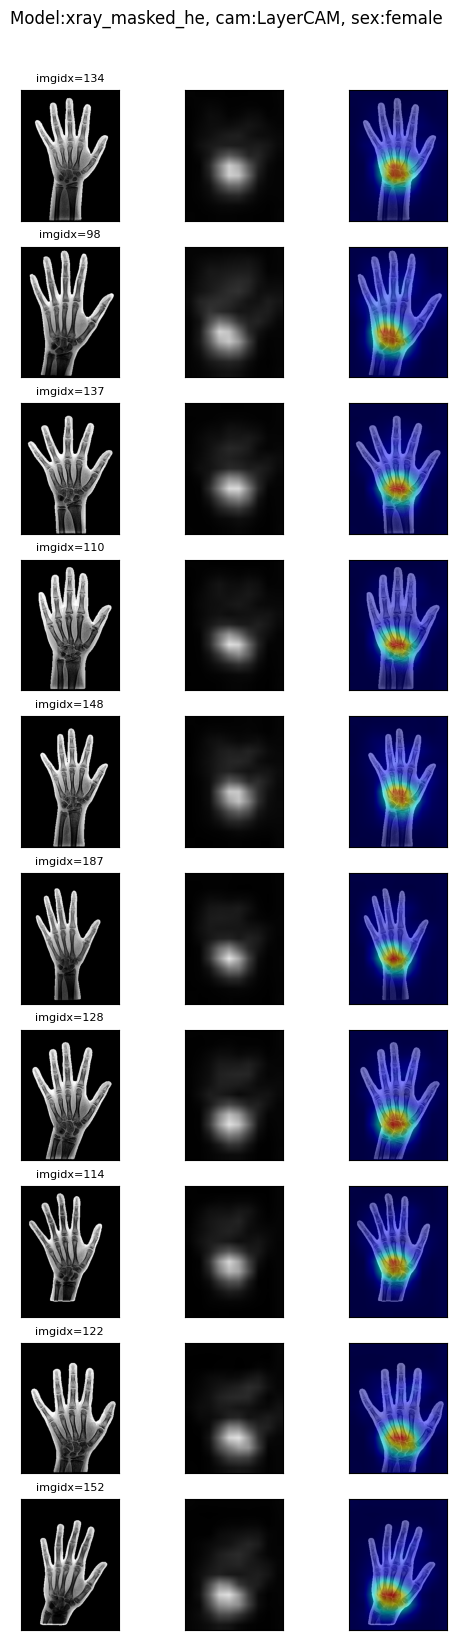

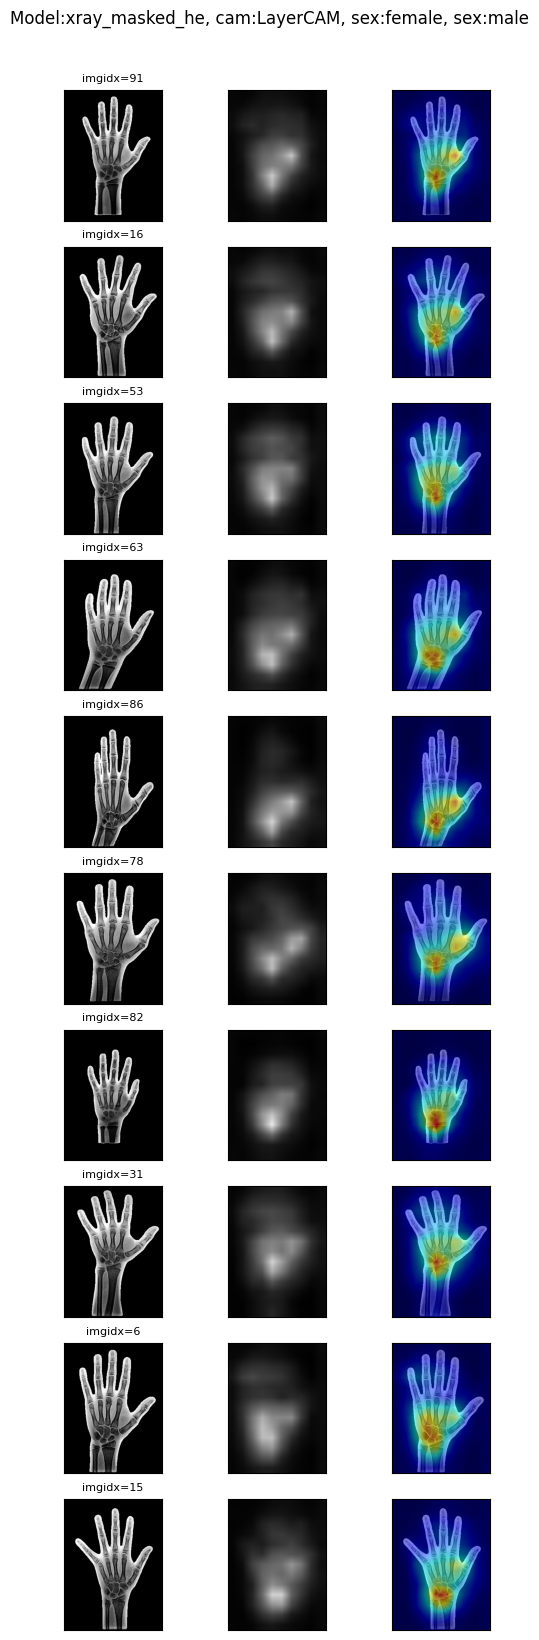

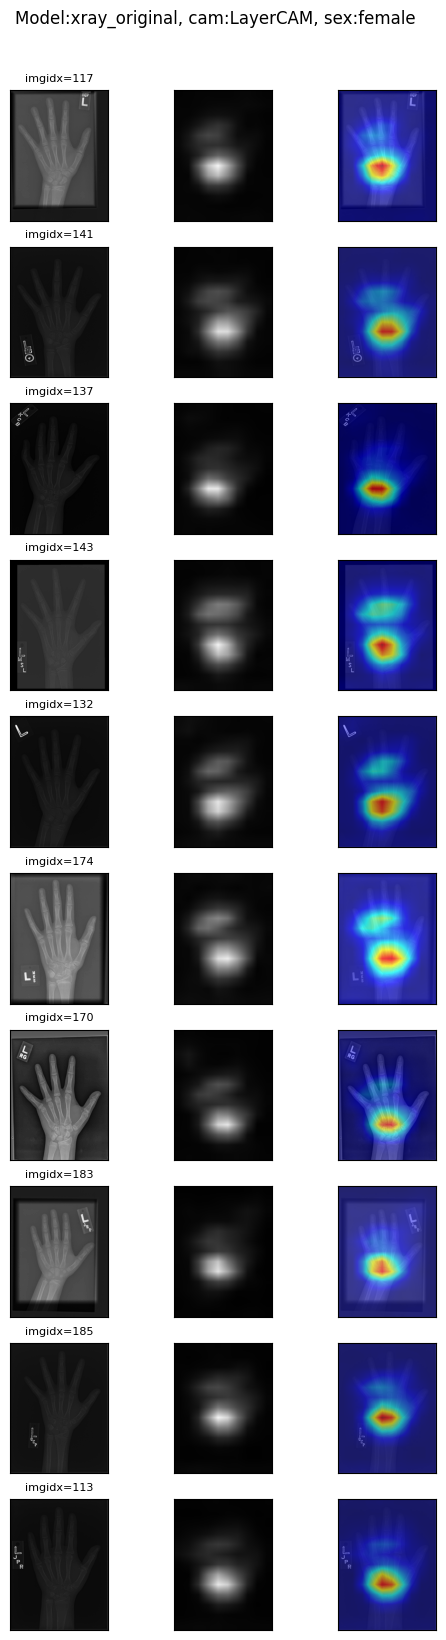

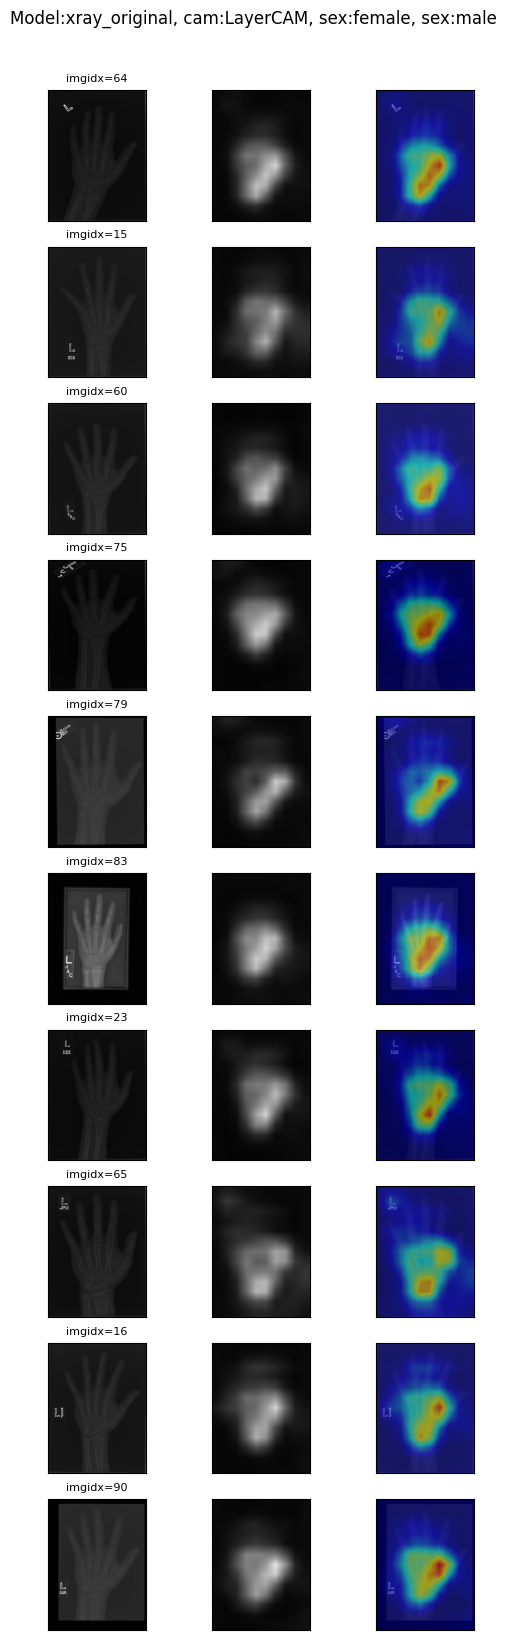

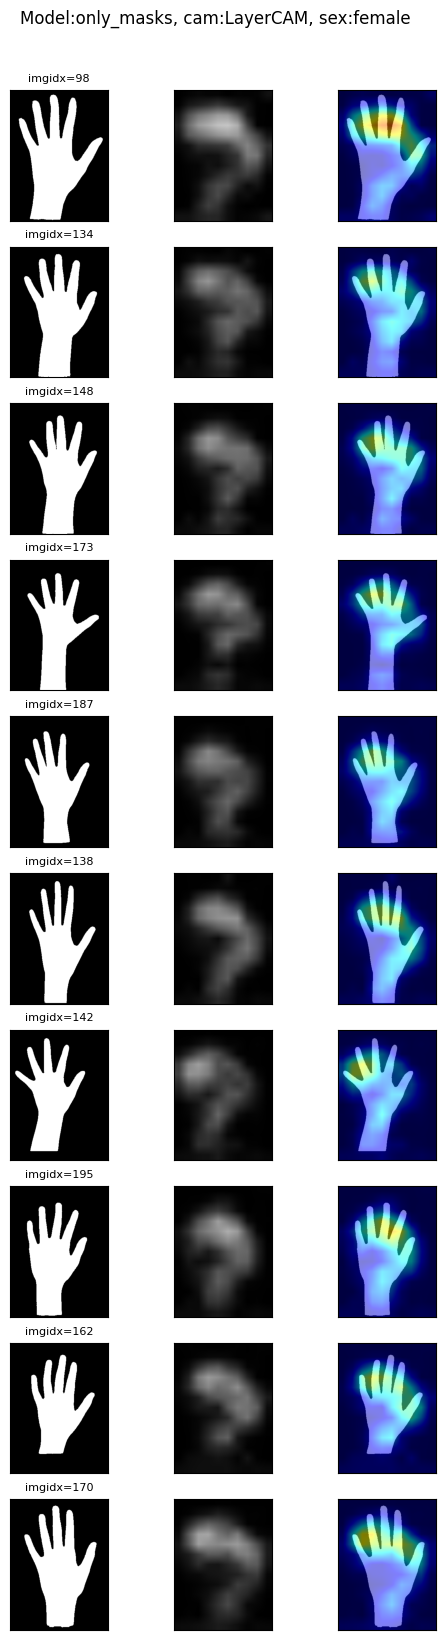

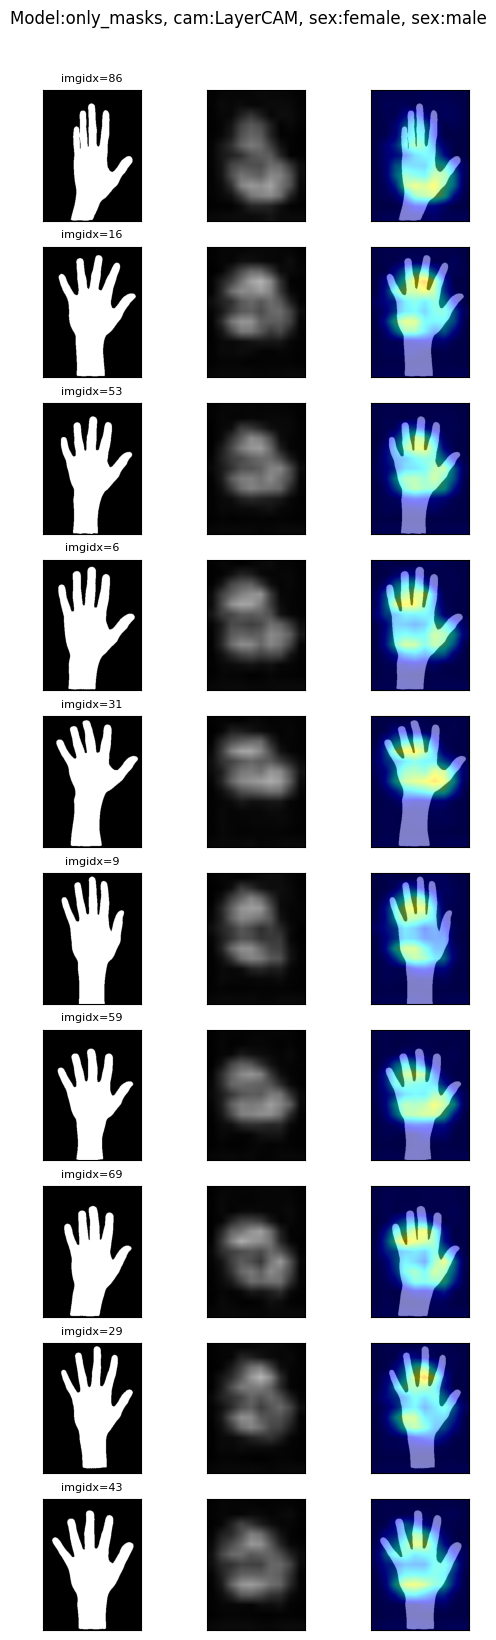

In [ ]:
#Visualization
def vizualization(directory_path, subfix, name, indexs, img, gray_cams):
    fig = plt.figure(figsize=(6, 20))
    axes = fig.subplots(len(indexs), 3)
    for j, idx in enumerate(indexs):
        axes[j,0].imshow(np.uint8(255*img[j])[:,:,0], cmap='gray')
        axes[j,0].set_xticks([])
        axes[j,0].set_yticks([])
        axes[j,0].set_title(f'imgidx={str(idx)}', fontsize=8)

        cam = np.uint8(255*gray_cams[j])
        cam = cv2.merge([cam, cam, cam])
        axes[j,1].imshow(cam)
        axes[j,1].set_xticks([])
        axes[j,1].set_yticks([])

        xray_image = np.array([img[j][:,:,0], img[j][:,:,0], img[j][:,:,0]]).transpose(1,2,0)
        cam_image = show_cam_on_image(xray_image, gray_cams[j], use_rgb=True)
        plt.imsave(directory_path+f'{str(idx)}{subfix}.png', cam_image)
        axes[j,2].imshow(cam_image)
        axes[j,2].set_xticks([])
        axes[j,2].set_yticks([])
        fig.suptitle(name, y=0.92)
    fig.savefig(directory_path+f'{name}.png')
    plt.show()

cam_method = 5
cam_names = ['GradCAM', 'GradCAMPlusPlus', 'XGradCAM', 'EigenCAM', 'HiResCAM',  'LayerCAM']
subfix = ['_l1_f', '_l1_m']
sex = ['female', 'male']

path = '/content/drive/MyDrive/ai-sex-class-paper-main/attributions/results/'
for d in range(len(models_names)): #by models

    directory_path = path + models_names[d] + '/' + cam_names[cam_method] + '/'
    if not os.path.exists(directory_path):
       os.makedirs(directory_path)
    name = f'Model:{models_names[d]}, cam:{cam_names[cam_method]}'

    for i  in range(data_sets_by_models): #by datasets female o male
        name = name + f', sex:{sex[i]}'
        vizualization(directory_path, subfix[i], name, data_sets_idxs[d][i], results_imgs[d][i],
                      finals_cams_by_models[d][i, :, cam_method, :, :])